# RandomSearch using Dask

In [18]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

from utils.mnist_reader import load_mnist
X_main, y_main = load_mnist("data/fashion", kind="train")
X_main = X_main.astype(np.float32)
y_main = y_main.astype(np.float32)

X_test, y_test = load_mnist("data/fashion", kind="t10k")
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

print (X_main.shape, y_main.shape)
print (X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


# Explore Data

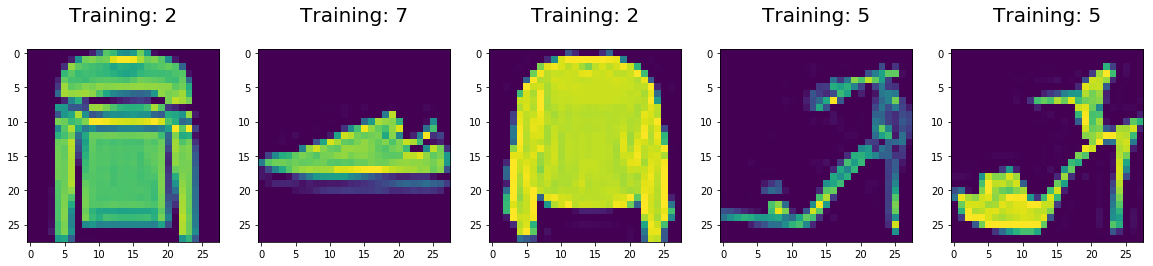

In [19]:
import numpy as np 
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(X_main[5:10], y_main[5:10])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap='viridis')
    plt.title('Training: %i\n' % label, fontsize = 20)

# Set up search space

In [20]:
from scipy.stats import randint as sp_randint

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Search (Using SKLearn locally)

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# from dask_ml.model_selection import RandomizedSearchCV
# from dask_ml.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20)

# run randomized search
random_search = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=5, 
                                   n_jobs=-1,
                                   verbose=10,
                                   iid=False)

In [13]:
%%time
random_search.fit(X_main, y_main)
print("RandomizedSearchCV examined %d candidates parameter settings." % n_iter_search)
report(random_search.cv_results_)

RandomizedSearchCV took 347.16 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.875 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 5, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.872 (std: 0.005)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 6}

Model with rank: 3
Mean validation score: 0.872 (std: 0.005)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 7}



# Search (Using Dask-ML in Cluster)

## 20 estimators, 20 iterations, 5 folds

In [ ]:
from dask.distributed import Client
client = Client('dask-scheduler:8786')  # connect to cluster
client

In [22]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression

from dask_ml.model_selection import RandomizedSearchCV
from dask_ml.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20)

# run randomized search
random_search = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=5, 
                                   n_jobs=-1,
                                   iid=False)

In [23]:
%%time
random_search.fit(X_main, y_main)
print("RandomizedSearchCV examined %d candidates parameter settings." % n_iter_search)
report(random_search.cv_results_)

RandomizedSearchCV examined 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.869 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 7, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.868 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.865 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 8}

CPU times: user 1.18 s, sys: 244 ms, total: 1.43 s
Wall time: 50 s


distributed.utils - ERROR - Timeout
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/opt/conda/lib/python3.7/site-packages/distributed/client.py", line 980, in _reconnect
    yield self._ensure_connected(timeout=timeout)
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 729, in run
    value = future.result()
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 736, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/opt/conda/lib/python3.7/site-packages/distributed/client.py", line 1025, in _ensure_connected
    msg = yield gen.with_timeout(timedelta(seconds=timeout), comm.read())
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 729, in run
    value = future.result()
tornado.util.TimeoutError: Timeout
distributed.utils - ERROR - Timeout
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-pack

## 100 estimators, 100 iterations, 20 folds

In [16]:
clf = RandomForestClassifier(n_estimators=100)

# run randomized search
random_search = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=20, 
                                   n_jobs=-1,
                                   iid=False)

In [17]:
%%time
random_search.fit(X_main, y_main)
print("RandomizedSearchCV examined %d candidates parameter settings." % n_iter_search)
report(random_search.cv_results_)

RandomizedSearchCV examined 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.881 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.880 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.879 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 8}

CPU times: user 10.7 s, sys: 1.76 s, total: 12.5 s
Wall time: 29min 6s
